# Geopricing with atoti
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/other-industries/geopricing/main.ipynb)._]

In this notebook we will explore a pricing use case that combines machine learning algorithms and atoti.  

Imagine our retailer has many shops spread across France. The idea behind this notebook is to group the shops based on its price index and geographical characteristics to its competitors.  
Price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.   
Through the clustering, we will be able to apply different pricing strategies on each cluster based on its competition.  

We shall obtain the clustering of the shops via machine learning.  
For the machine learning, we will need a set of input features for each retail shops:
- Number of competitors per distance range (1km, 5km, 10km etc)
- Price Index per shop against its competitors  

We will see how we can generate these input values for the machine learning with atoti.  
Not only so, we will also make use of output from the machine learning to perform the below simulations:
- Pricing simulations around clusters to obtain the optimised price index against its neighbouring competitors
- Selling price simulation by clusters and retail shops to align the pricing within the cluster

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=geopricing" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

### Dependencies
Assuming atoti is already installed, let's start by installing the additional libraries required for this notebook to work.

In [1]:
import sys

import atoti as tt
import numpy as np
import pandas as pd

# !conda install --yes --prefix {sys.prefix} folium scipy scikit-learn matplotlib seaborn

## Data Preparation and exploration with atoti

Let's start by loading our data into atoti stores.

In [2]:
session = tt.Session(user_content_storage="content", java_options=["-Xmx32G"])

In [3]:
#  We used pandas to read the selling price here as we will be using it again for price optimisation in the later section.
product_sales_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/product_pricing.csv"
)

productSales = session.read_pandas(
    product_sales_df,
    keys=["ProductId", "ShopId"],
    table_name="ProductSales",
    types={"ProductId": tt.type.INT, "ShopId": tt.type.INT},
)
productSales.head()

SellingPrice  PurchasePrice  Quantity
ProductId ShopId                                       
4096      1               1.92          1.632    6804.0
          6               1.99          1.695    3331.0
          22              1.78          1.456    2541.0
          29              1.73          1.490    2839.0
4097      27              2.06          1.767    1719.0

Due to the amount of data in this store, the store is sampled by default. We will proceed to load all the data only after we are done modeling the cube.

We will also require the competitors' product pricing against our shops.

In [4]:
competitorPrices_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/competitors_prices.csv"
)

competitorPrices = session.read_pandas(
    competitorPrices_df,
    keys=["ProductId", "CompetitorShopId", "ShopId"],
    table_name="CompetitorPrices",
    types={
        "ProductId": tt.type.INT,
        "ShopId": tt.type.INT,
        "CompetitorShopId": tt.type.INT,
    },
)
competitorPrices.head()

,,,CompetitorPrice
ProductId,CompetitorShopId,ShopId,
4096,101,1,2.287
4111,101,1,1.966
4145,101,1,1.901
4235,101,1,2.467
6011,101,1,1.974


We have the key stores necessary for us to generate the data required for machine learning.  
However, we will also load the following stores that will allow us to have a more in-depth analysis:
- Products: Product catalogue
- Shops: shops information such as location
- CompetitorsShops: Competitors' shop information

In [5]:
products_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/products_info.csv", sep=";"
)

products = session.read_pandas(
    products_df,
    keys=["ProductId"],
    table_name="Products",
)
products.head()

,EAN,ProductName,Brand,Size,Unit,Department,SubDepartment,Category,SubCategory
ProductId,,,,,,,,,
4116,3124480002686,"1,5L SCHWEPPES AGRUM ZERO PET",SCHWEPPES,1.5,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS GAZEUX,PET - PVC
4145,5449000133328,1L COCA COLA ZERO PET,COCA COLA,1,L,LIQUIDES,SOFT TRADITIONNELS,COLAS,PET - PVC
4171,3502110007636,"1,5L 7UP SAVEUR MOJITO FREE",SEVEN UP,1.5,L,LIQUIDES,SOFT TRADITIONNELS,LIMONADE / LIMES,LIMES
4219,5060108450263,50CL FEVER TREE TONIC WATER,FEVER TREE,50,cl,LIQUIDES,SOFT TRADITIONNELS,TONIC,GINGER ALE
6004,5601083001585,"75CL PORTO RUBY 19,5°SANDEMAN",SANDEMAN,0.75,L,LIQUIDES,APERITIF BASE VIN,APERITIF BASE ALCOOL,PORTOS


In [6]:
shops_df = pd.read_csv("https://data.atoti.io/notebooks/geopricing/shops.csv", sep=";")

shops = session.read_pandas(
    shops_df,
    keys=["ShopId"],
    table_name="Shops",
    types={"ShopId": tt.type.INT},
)
shops.head()

,ShopName,Address,ZipCode,City,Country,Latitude,Longitude,Company
ShopId,,,,,,,,
19,MyShop Lille,Lille,59000,Lille,France,50.633300,3.066670,MyCompany
39,MyShop Montreuil,Montreuil,93100,Montreuil,France,48.866700,2.433330,MyCompany
20,MyShop Rennes,Rennes,35000,Rennes,France,48.083300,-1.683330,MyCompany
40,MyShop Roubaix,Roubaix,59100,Roubaix,France,50.700000,3.166670,MyCompany
1,MyShop Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,MyCompany


In [7]:
competitorShops_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/competitors_shops.csv", sep=";"
)

competitorShops = session.read_pandas(
    competitorShops_df,
    keys=["CompetitorShopId"],
    table_name="CompetitorsShop",
    types={"CompetitorShopId": tt.type.INT},
)
competitorShops.head()

,CompetitorShopName,CompetitorShopAdress,CompetitorShopZipCode,CompetitorShopCity,CompetitorShopCountry,CompetitorShopLatitude,CompetitorShopLongitude,CompetitorShopCompany
CompetitorShopId,,,,,,,,
137,Concurrent Premium,Nancy,54100,Nancy,France,48.683300,6.200000,Concurrent Premium
226,Concurrent Direct 1,Dijon,21000,Dijon,France,47.316700,5.016670,Concurrent Direct 1
310,Concurrent Direct 2,Paris 9,75009,Paris,France,48.877661,2.327911,Concurrent Direct 2
406,Concurrent Direct 3,Paris 5,75005,Paris,France,48.846036,2.354722,Concurrent Direct 3
442,Concurrent Direct 3,Tourcoing,59200,Tourcoing,France,50.716700,3.150000,Concurrent Direct 3


Since we have the latitude and longitude of the shops and their competitors, we pre-computed distances in between using the [harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula) and load into the data store.  
Note that another approach would be to use instead something like the [google API](https://developers.google.com/maps/documentation/distance-matrix/intro) to compute distances and durations between two points (thus taking into accounts possible means of transportation).

In [8]:
import os
import sys

module_path = os.path.abspath(os.path.join("."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
from _utils import geo_utils

shops_distances_matrix = geo_utils.create_shops_distances_matrix(
    shops_df, competitorShops_df
)

distance_matrix = session.read_pandas(
    shops_distances_matrix,
    keys=["ShopId", "CompetitorShopId"],
    table_name="DistanceMatrix",
    types={"ShopId": tt.type.INT, "CompetitorShopId": tt.type.INT},
)
distance_matrix.head()

Competitor distance KM
CompetitorShopId ShopId                        
101              1                     0.000000
                 5                     4.547896
                 8                     2.789670
                 29                  346.500447
                 39                    6.667987

We choose _ProductSales_ as our base store as it contains the key facts for our shops. Look at [atoti tutorial](https://docs.atoti.io/0.4.1/tutorial/01-Basics.html) to understanding the cube better.   
Correspondingly, we have our _CompetitorPrices_ store that has a many-to-many relationship with our _ProductSales_ since multiple shops can sell the same products.
 
We can easily setup this many-to-many relationship simply by joining the _CompetitorPrices_ store to our _ProductSales_ store by _ProductId_ and _ShopId_.

In [10]:
price_index_cube = session.create_cube(productSales, "PriceIndexCube")

In [11]:
productSales.join(
    competitorPrices,
    (productSales["ProductId"] == competitorPrices["ProductId"])
    & (productSales["ShopId"] == competitorPrices["ShopId"]),
)

Let's also enrich our cube with extra information about the shops to create a [snowflake schema](https://www.geeksforgeeks.org/snowflake-schema-in-data-warehouse-model/).

In [12]:
productSales.join(products, productSales["ProductId"] == products["ProductId"])
productSales.join(shops, productSales["ShopId"] == shops["ShopId"])
competitorPrices.join(
    competitorShops,
    competitorPrices["CompetitorShopId"] == competitorShops["CompetitorShopId"],
)
competitorPrices.join(
    distance_matrix,
    (competitorPrices["CompetitorShopId"] == distance_matrix["CompetitorShopId"])
    & (competitorPrices["ShopId"] == distance_matrix["ShopId"]),
)

Let's see the final design of our cube.

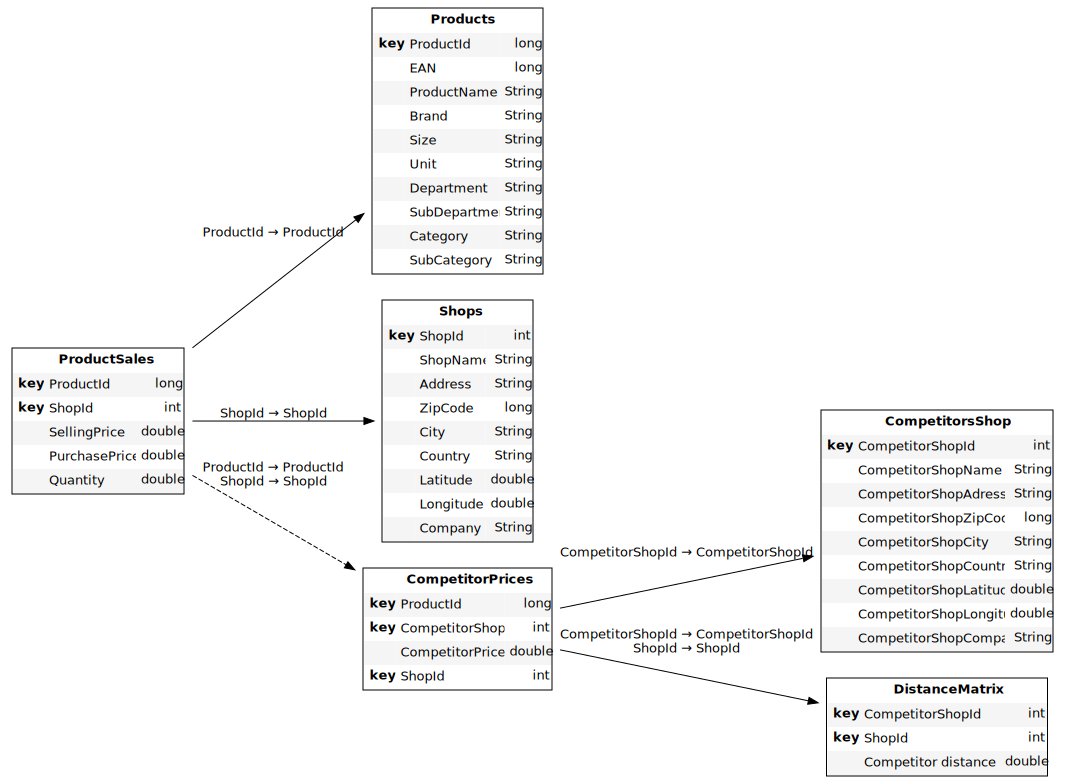

In [13]:
price_index_cube.schema

In [14]:
h = price_index_cube.hierarchies
m = price_index_cube.measures
lvl = price_index_cube.levels

In [15]:
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x0000022D2F12C7F0>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x0000022D2F7CF100>, 'Quantity.SUM': <atoti.measure.Measure object at 0x0000022D2F7CF130>, 'Quantity.MEAN': <atoti.measure.Measure object at 0x0000022D2F7CF190>, 'SellingPrice.SUM': <atoti.measure.Measure object at 0x0000022D2F7CF1F0>, 'SellingPrice.MEAN': <atoti.measure.Measure object at 0x0000022D2F7CF220>, 'PurchasePrice.SUM': <atoti.measure.Measure object at 0x0000022D2F7CF250>, 'PurchasePrice.MEAN': <atoti.measure.Measure object at 0x0000022D2F7CF280>}

We can see a _SUM_ and _MEAN_ measure is created columns of type double/float for the base store - _ProductSales_.  
A _VALUE_ measure is created for columns of type double/float in the other referenced stores.  

With the cube created, let's start by computing the number of competitors per distance bucket (distance radius from the shop).

### 1. Computing number of Competitors per Distance Bucket  

There are many ways to do compute the number of competitors per distance buckets. However, we are going to showcase how we can make use of the simulations to create the distance buckets. The advantage of doing so is that we can easily create new distance bucket with minimum coding.

Let's create a measure call `m["Distance Threshold"]` that contains the value for the distance threshold for each bucket and we start by looking at the number of competitors within 1km distance radius from our shop.

In [16]:
m["Distance Threshold"] = 1

Due to the join to the _CompetitorsPrice_ store, the `m["Contributor.COUNT]` returned is based on the products.  
We want to obtain the number of distinct competitors' shops that sell the same products as us, not the number of products.  

To do so, we look at the the average distance between the shop and its competitor, returning a count of 1 if it is located within our threshold radius.

In [17]:
m["Competitor distance KM.VALUE"] = tt.agg.single_value(
    distance_matrix["Competitor distance KM"]
)
m["Count within distance threshold"] = tt.agg.sum(
    tt.where(
        tt.agg.mean(
            m["Competitor distance KM.VALUE"],
            scope=tt.OriginScope(lvl["ShopId"], lvl["CompetitorShopId"]),
        )
        < m["Distance Threshold"],
        1,
        0,
    ),
    scope=tt.OriginScope(lvl["ShopId"], lvl["CompetitorShopId"]),
)

Naturally we can quickly use Pandas to derive the same value. However, when we use this one time setup together with simulations, we have the below benefits:
- easily add / delete the distance buckets
- ability to drill down on the data for each distance range to perform further analysis

#### Setting up simulation for distance buckets
We setup a simulation where we can replace the threshold value in order to be able to create scenarios for other ranges of distance.  
We name this base scenario "1km".

In [18]:
simulation = price_index_cube.create_parameter_simulation(
    name="Distance Simulation", measures={"Distance Threshold": 1}
)

lvl["Distance Simulation"].order = tt.NaturalOrder(ascending=True)

We can now easily obtain the number of competitors per area simply by creating a scenario for each distance radius.  
With this, we can easily create new distance buckets to generate different datasets for the machine learning.

In [19]:
simulation += ("01 Km", 1)
simulation += ("05 Km", 5)
simulation += ("10 Km", 10)
simulation += ("15 km", 15)
simulation += ("20 Km", 20)

Let's remove the limit on the number of point locations.

In [20]:
price_index_cube.shared_context["queriesResultLimit.intermediateLimit"] = -1
price_index_cube.shared_context["queriesResultLimit.transientLimit"] = -1

Let's do a quick data-viz to see how the number of competitors varies by the distance.

In [21]:
session.visualize("Nr of competitors by distance bucket")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2. Computing the price index per shop

There are different existing formulas for the price index. The formula we will use in this example compares a product price to the average price found among the local competitors of a particular shop, measuring at which percentage of this average competitors price the product is.

We will weight the price index indicator by the margin when aggregating above shop and product level. This is so that we can later optimize the price index for products that contribute the most to the margin. Other commonly used formulas weight by sales quantity or revenue.

#### Price index formula:

# $100 \times \frac{\sum_{s,p \in (Shops,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}{\sum_{s,p \in (Shops,Products)}Margin(s,p)}$  

Let's create a measure to get the mean of _CompetitorPrice_ which will be used to derive the price index.  
We are only interested in the relevant _CompetitorPrice_ of competitors within the _distance threshold_. 

In [22]:
m["CompetitorPrice.VALUE"] = tt.agg.single_value(competitorPrices["CompetitorPrice"])
m["CompetitorPrice.MEAN"] = tt.agg.mean(
    tt.where(
        m["Competitor distance KM.VALUE"] < m["Distance Threshold"],
        m["CompetitorPrice.VALUE"],
        None,
    ),
    scope=tt.OriginScope(lvl["ShopId"], lvl["CompetitorShopId"]),
)
m["CompetitorPrice.MEAN"].formatter = "DOUBLE[#,###.00]"

Instead of using Pandas to do pre-aggregation, we perform the margin computation with atoti so that we can see the change in its value after we optimise the selling price later on.

In [23]:
m["Margin.SUM"] = tt.agg.sum(
    (m["SellingPrice.SUM"] - m["PurchasePrice.SUM"]) * m["Quantity.SUM"],
    scope=tt.OriginScope(lvl["ProductId"], lvl["ShopId"]),
)

We see how the weight price index indicator can be achieved in the next few cells.  
Realize how we are setting the scope on _ProductId_ and _ShopId_? This will ensure the summation of the various measures at the _Shops_ and _Product_ level as required by the formula:

# ${\sum_{s,p \in (Shops,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}$

In [24]:
price_index_numerator = tt.agg.sum(
    (m["SellingPrice.SUM"] * m["Margin.SUM"]) / m["CompetitorPrice.MEAN"],
    scope=tt.OriginScope(lvl["ProductId"], lvl["ShopId"]),
)

Finally, we calculate the contribution of the product towards the total margin.

In [25]:
m["Price Index"] = price_index_numerator / m["Margin.SUM"]

Let's visualize the price index per shop.

In [26]:
session.visualize("Price index by shops and distance")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

How do we systematically make use of this information?   
Let's use the _Competitors count within radius_ for each distance bucket and _PriceIndex_ computed above - to train a model and clusterize the stores.  
We can extract these data from atoti as shown in the function below:

In [27]:
def get_features():
    # output dataframe for competitors count per shop & area (distance radius) from cube querying
    shops_competitors_count_per_shop_area = price_index_cube.query(
        m["Count within distance threshold"],
        levels=[lvl["ShopId"], lvl["Distance Simulation"]],
        mode="raw",
    ).reset_index()

    # pivot the table such that each scenario becomes a column
    shops_competitors_count_per_shop_area = shops_competitors_count_per_shop_area.pivot(
        index="ShopId",
        columns="Distance Simulation",
        values="Count within distance threshold",
    )

    # output dataframe for price index by shop from cube querying
    price_index_per_shop_area = price_index_cube.query(
        m["Price Index"], levels=[lvl["ShopId"], lvl["Distance Simulation"]], mode="raw"
    ).reset_index()

    # pivot the table such that each scenario becomes a column
    price_index_per_shop_area = price_index_per_shop_area.pivot(
        index="ShopId",
        columns="Distance Simulation",
        values="Price Index",
    )

    # merge the 2 dataframe and return the output
    shops_features = pd.merge(
        shops_competitors_count_per_shop_area,
        price_index_per_shop_area,
        left_on="ShopId",
        right_on="ShopId",
        how="left",
        suffixes=("", "_Price Index"),
    ).fillna(1)

    return shops_features

## 3. Machine Learning - Shops clustering using price index and competitors number features
We can use a machine algorithm such as k-means to make clusters with the features (01km, 05km, 10km, 15km, 20km, Price Index) that we obtained from the cube:

In [28]:
shops_features = get_features()
shops_features.head(15)

Distance Simulation,01 Km,05 Km,10 Km,15 km,20 Km,Base,01 Km_Price Index,05 Km_Price Index,10 Km_Price Index,15 km_Price Index,20 Km_Price Index,Base_Price Index
ShopId,,,,,,,,,,,,
1,11,51,66,71,71,11,0.971768,0.967427,0.979813,0.984359,0.984359,0.971768
2,5,46,61,71,71,5,1.019849,1.028944,1.033745,1.040784,1.040784,1.019849
3,5,36,71,71,71,5,0.942543,0.947768,0.957931,0.957931,0.957931,0.942543
4,5,31,61,66,71,5,0.932070,0.941728,0.959149,0.962671,0.967199,0.932070
5,5,36,56,71,71,5,0.996250,1.023378,1.015577,1.028509,1.028509,0.996250
6,5,46,66,71,71,5,0.982229,1.010644,1.020678,1.025247,1.025247,0.982229
7,11,51,66,71,71,11,1.065508,1.061969,1.073039,1.077096,1.077096,1.065508
8,5,46,66,71,71,5,1.002567,1.026161,1.025980,1.030540,1.030540,1.002567
9,5,46,66,71,71,5,1.024447,0.991471,1.001022,1.005239,1.005239,1.024447


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

sns.set()  # for plot styling

Let's set the number of clusters needed as 5. The number of clusters can increase if the number of shops is huge.  
We apply the k-mean on the _shops\_feature_ from above.

In [30]:
np_shops_features = np.ascontiguousarray(shops_features)

In [31]:
number_of_clusters = 5
kmeans = MiniBatchKMeans(number_of_clusters)
kmeans.fit(np_shops_features)
new_colors = kmeans.cluster_centers_[kmeans.predict(np_shops_features)]
k_means_labels = pairwise_distances_argmin(np_shops_features, kmeans.cluster_centers_)
labels = KMeans(number_of_clusters, random_state=0).fit_predict(np_shops_features)

Using competitors within 1km as an example, we can now analyze the result of the clustering by pair of features using matplotlib as shown below:

Text(0, 0.5, 'Price Index')

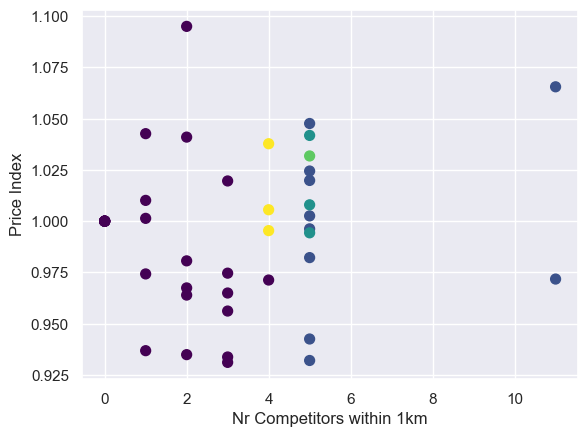

In [32]:
plt.scatter(
    shops_features.loc[:, "01 Km"],
    shops_features.loc[:, "01 Km_Price Index"],
    c=k_means_labels,
    s=50,
    cmap="viridis",
)

plt.xlabel("Nr Competitors within 1km")
plt.ylabel("Price Index")

In the above plot, each color represents a cluster. We can see that clusters seem to be strongly based on the number of competitors rather than on the price index.  
However, to avoid having to plot every couple of features and understand more quickly what our clusters are, we will use seaborn to have a plot of the clustering result for every pair of features.

In [33]:
shops_features["Cluster"] = labels
shops_features.head(5)

Distance Simulation,01 Km,05 Km,10 Km,15 km,20 Km,Base,01 Km_Price Index,05 Km_Price Index,10 Km_Price Index,15 km_Price Index,20 Km_Price Index,Base_Price Index,Cluster
ShopId,,,,,,,,,,,,,
1,11,51,66,71,71,11,0.971768,0.967427,0.979813,0.984359,0.984359,0.971768,2
2,5,46,61,71,71,5,1.019849,1.028944,1.033745,1.040784,1.040784,1.019849,2
3,5,36,71,71,71,5,0.942543,0.947768,0.957931,0.957931,0.957931,0.942543,2
4,5,31,61,66,71,5,0.932070,0.941728,0.959149,0.962671,0.967199,0.932070,2
5,5,36,56,71,71,5,0.996250,1.023378,1.015577,1.028509,1.028509,0.996250,2


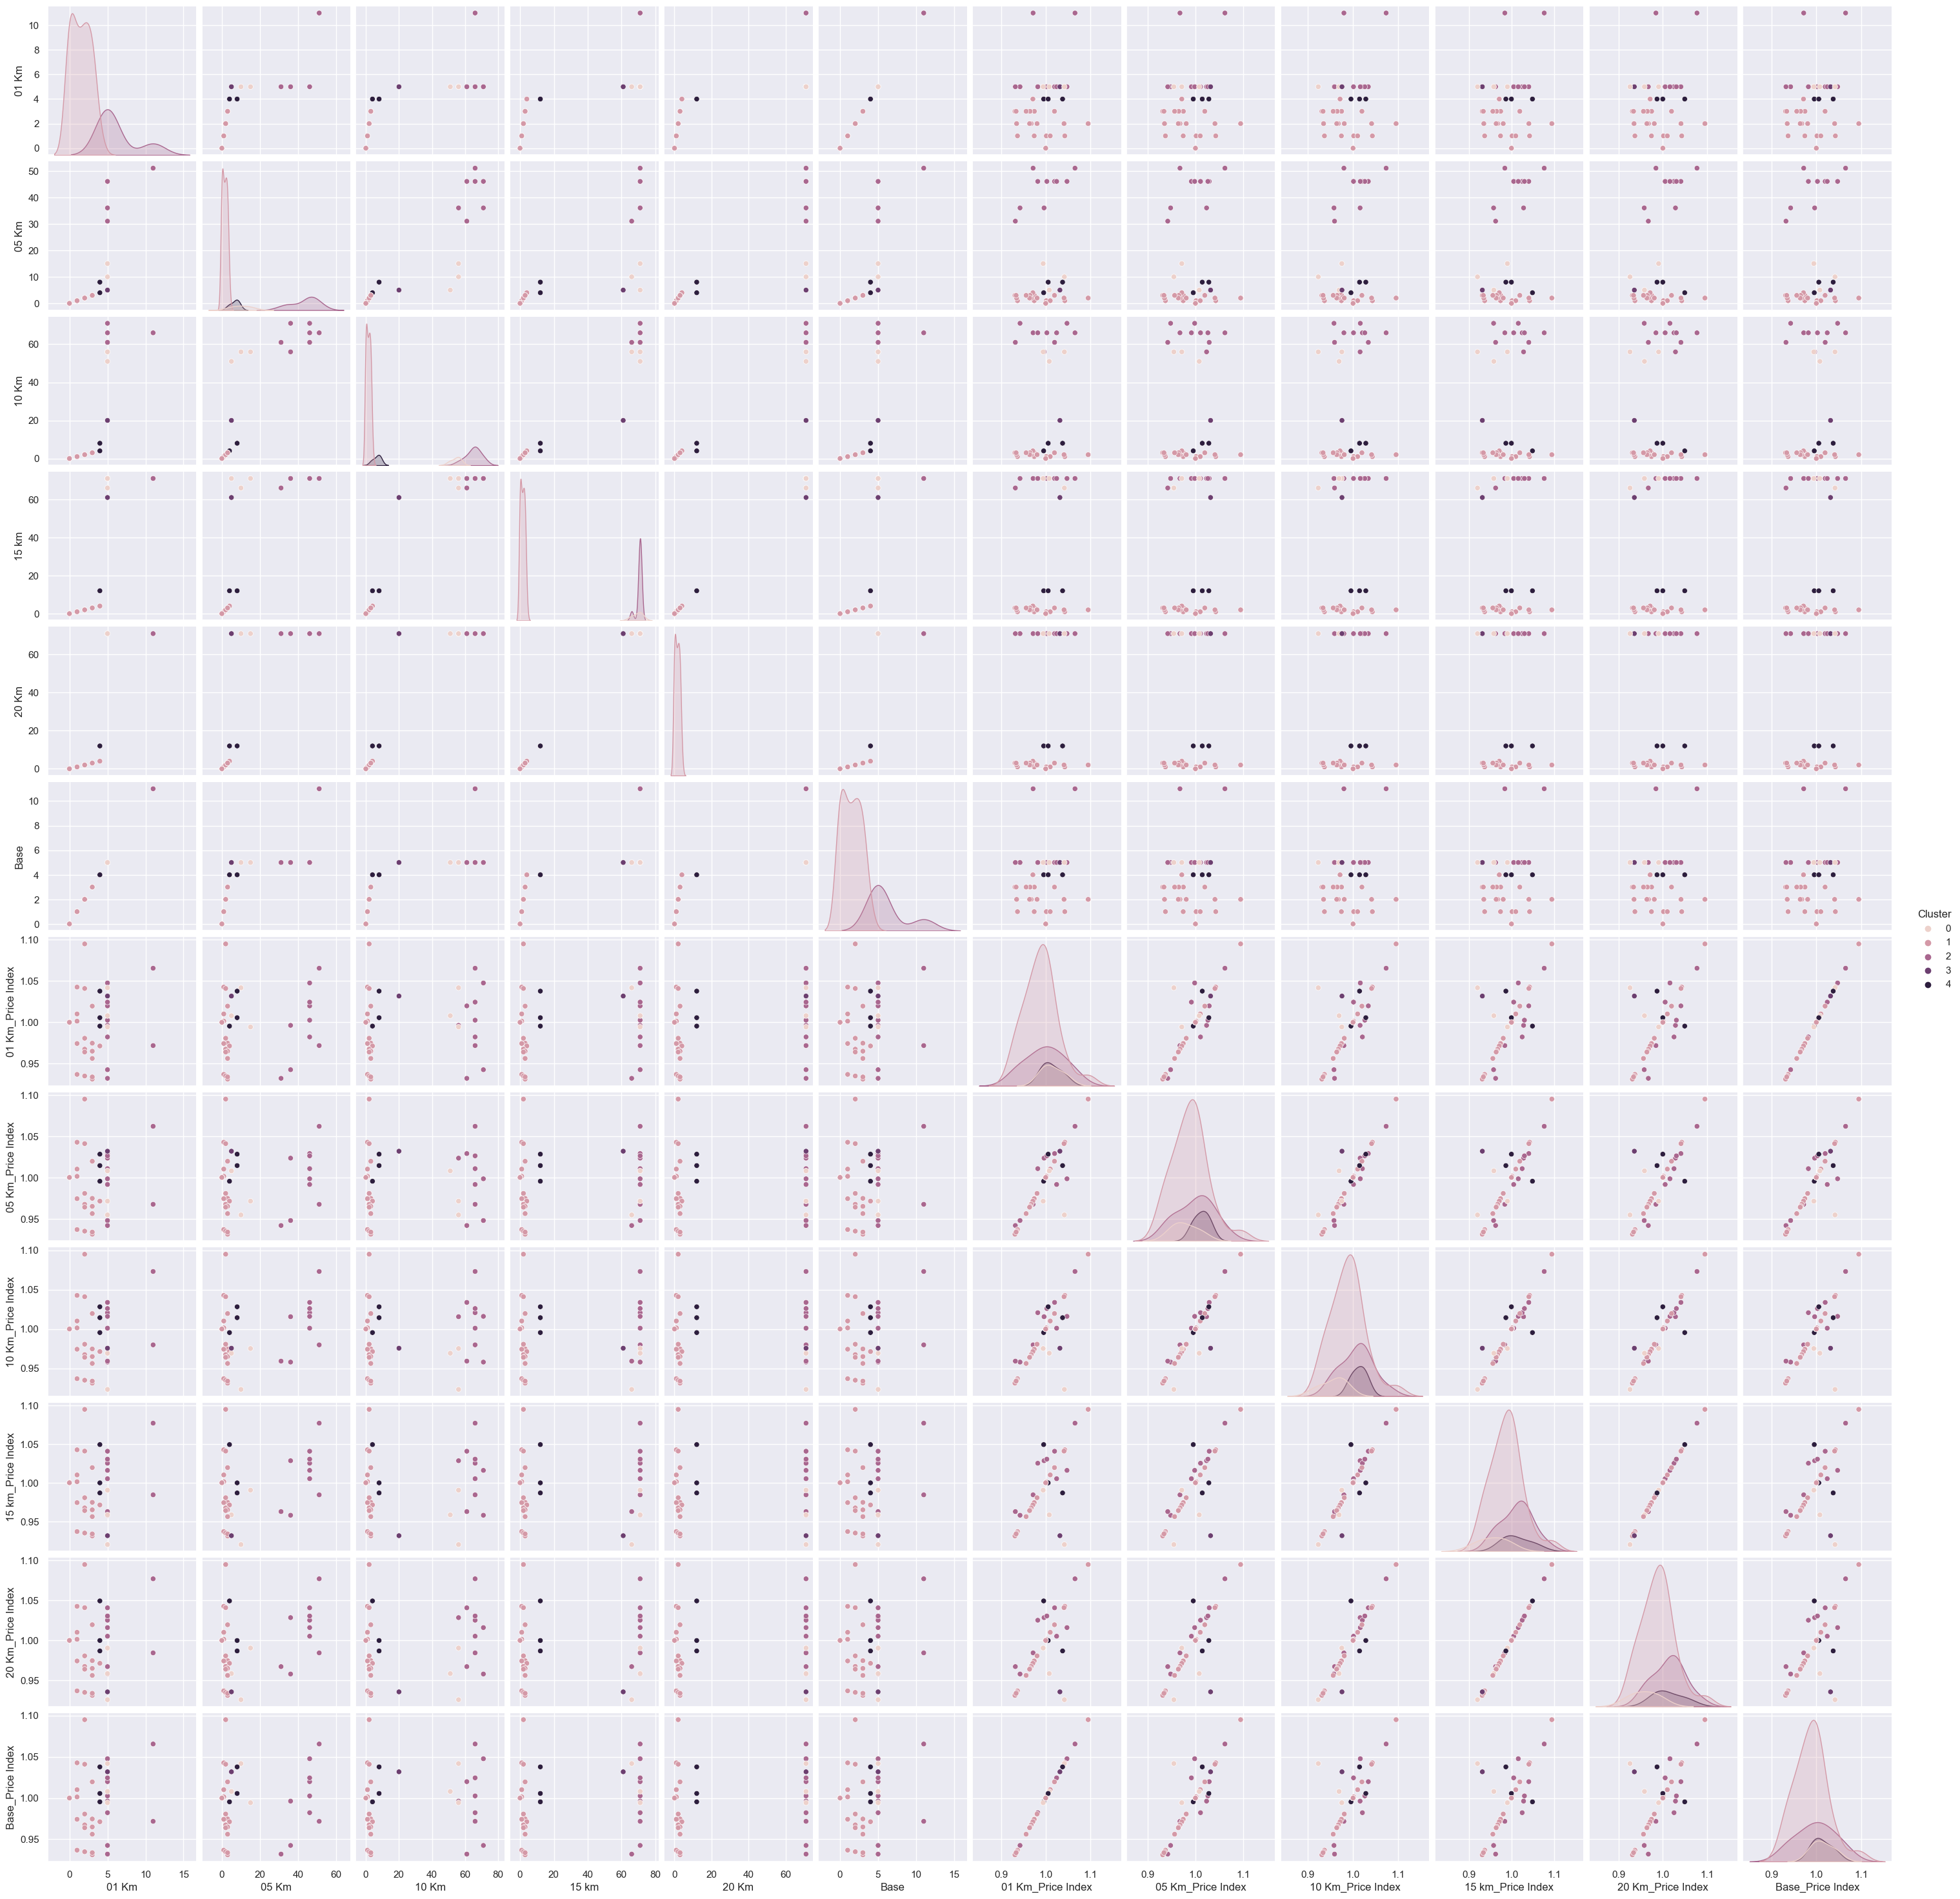

In [34]:
sns.pairplot(data=shops_features, hue="Cluster")

We can have a better understanding of the clusters with the chart above.  
Within 1km distance radius, price index across the clusters are generally around 1. 
The stores in cluster 1 have a much higher number of competitors (>40) in a 5km radius, compared to those of cluster 0 having less than 20 competitors within 20km radius.  
While cluster 1 has more competitors, its price index is generally higher than cluster 0 and greater than 1.

Continuing this analysis tells us that:
- Cluster 0 is a big cluster with little competitors around and its price index is generally around 1.
- Cluster 1 has a high number of competitors even within a 5km distance radius. However its price index is slightly skewed towards a higher price index even with the high competition.
- Cluster 2 is a small cluster and the number of competitors increases tremendously as the distance radius increases. Generally it has a lower price index against its competitors.
- Cluster 3 is a small cluster and the number of competitors remains about the same across all buckets. Its price index remains consistent around 1 across the distance bucket, although one of its shops started having a higher price index and the rest fall below 1 as we consider competitors in the 15-20km radius.
- Cluster 4 is a small cluster that has a higher price index against the nearest competitors. This is reasonable considering the number of competitors nearby is not high. The price index becomes much lower as the number of competitors increases from 15km onwards.

While this gives us an idea of how to position ourselves, we need to put these into context before we can decide on what pricing strategy to apply on it.  
Let's load the new cluster back into the cube to have more in-depth analysis.

## 4. Interpreting the machine learning output with atoti

Let's load the cluster results obtained from the machine learning model into the cube.

In [35]:
clusters_df = shops_features[["Cluster"]].reset_index()
clusters_df.ShopId = clusters_df.ShopId.astype("int32")
clusters = session.read_pandas(
    clusters_df, keys=["ShopId"], table_name="Clusters", default_values={"Cluster": 0}
)

clusters.head(5)

,Cluster
ShopId,
19,4
39,0
20,1
40,4
1,2


In [36]:
shops.join(clusters)

In [37]:
price_index_cube.hierarchies["Cluster"] = [clusters["Cluster"]]

In [38]:
shops

In [39]:
m["Longitude.VALUE"] = tt.agg.single_value(shops["Longitude"])
m["Latitude.VALUE"] = tt.agg.single_value(shops["Latitude"])

In [40]:
session.visualize("Spread of clusters by longitude and latitude within 5 km")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Interestingly, cluster 1 (orange) is distributed across the longitude and latitude, and mostly they are the only shop in the neighbourhood that is under our retailer. There are few competitors in the area.  
Cluster 4 is a small cluster around Lille, the capital of the Hauts-de-France region in northern France.  
The rest of the clusters have shops under our retailer in close proximity, and most of them spread around Paris.
The size of the points on the map reflects the number of competitors within 5km - we can see the competition around the city is the highest, specifically for cluster 2 (red).

In the case of cluster 1, the shop is the only one under the retailer in the neighbourhood. The number of competitors is low, hence the price index is less affected by competition.  
Rather, other factors such as variety of products, branding etc could take on a heavier factor on the price index - these are to be considered when applying a pricing strategy for this cluster. Generally, the price index could be higher.  

For the rest of the clusters, there are a few considerations. Within the same proximity, the shops face the same competitors.  
Not only that, consumers can easily detect the price differences of products between the shops of the same retailer if they are close to one another.  
Hence it makes more sense to align their price index and it should be slightly lower to push up its competitiveness.

## 5. Pricing simulations around clusters

We will now generate new prices using the clustering information in order to take into account the different competitiveness constraints of the shops.  

Using the clusters generated, the below pricing method tries to reduce the prices if the competitiveness is strong, and on the contrary increase it if there is few competition.  
For instance, cluster 0 and cluster 4 has little competition, hence their price index could be slightly higher than 1.  
The rest of the clusters have more competitors within 10km radius, hence could have their price index at 1 or slightly lower to maintain their competitivity.  

In [41]:
from _utils import pricer

selling_prices_based_on_clusters = pricer.optimize_prices(product_sales_df, clusters_df)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [42]:
productSales.scenarios["Selling prices based on clusters"].load_pandas(
    selling_prices_based_on_clusters
)

In [43]:
session.visualize("Price Optimisation impact on Price Index and Margin")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index and margin, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.  

We see an increase in margin for all clusters except for cluster 2.  
Although the overall margin has decreased, we should have an increase in sales if the strategy works well and subsequently an increase in the overall margin.

We saw the adjustment in price index at the cluster level and we could easily drill down to the shop and even product level.  
Now, let's visualize the changes in price index for the 5 clusters.

In [44]:
session.visualize("Price index optimisation difference")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In order to attract more customers, we can see that the pricing method decreased the pricing for cluster 2, which faced high competitions.  
On the contrary it increased the prices in shops belonging to low competition clusters in order to maximize margin.  
Cluster 0, 1 and 4 for instance, have fewer competitors. Hence their selling prices are adjusted higher, resulting in higher price index.

#### Interactive GeoPricing Monitoring Dashboard

In [45]:
session.link(path="#/dashboard/1bb")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Click on the above URL to access the interactive GeoPricing Monitoring dashboard.  
Zoom in on the map and click on any store to see how its price index and margin are influenced by the number of competitors within a given distance threshold.

## 6. Selling price simulation by clusters and shops

Zooming in on cluster 2, we see that _MyShop Paris 6_ has one of the highest competition within the cluster.  
<img src="https://data.atoti.io/notebooks/geopricing/cluster2-nbrCompetitors.gif" alt="Clustering 2, Store 6" style="width:1200px;"/>

However, looking at the chart below, the store also has a relatively high price index within the cluster.  
Likewise, _MyShop Paris 9_ also has a relatively high price index within the cluster even if the competition is just slightly lesser.

In [46]:
session.visualize("Price index for cluster 2")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's scale down the price index of these 2 shops using atoti's measure simulation.

In [47]:
price_simulation = price_index_cube.create_parameter_simulation(
    name="Price simulation",
    measures={"SellingPriceParam": 1.0},
    levels=[lvl["ShopId"]],
)

In [48]:
m["selling_price"] = m["SellingPrice.SUM"] * m["SellingPriceParam"]

We need to update the definition of price_index_numerator and m["Margin.SUM"], to take into account the simulations. 

In [49]:
price_index_numerator = tt.agg.sum(
    (m["selling_price"] * m["Margin.SUM"]) / m["CompetitorPrice.MEAN"],
    scope=tt.OriginScope(lvl["ProductId"], lvl["ShopId"]),
)

In [50]:
m["Margin.SUM"] = tt.agg.sum(
    (m["selling_price"] - m["PurchasePrice.SUM"]) * m["Quantity.SUM"],
    scope=tt.OriginScope(lvl["ProductId"], lvl["ShopId"]),
)

We are now able to scale the _Selling Price_ either across clusters or by specific shop.

In [51]:
price_simulation += ("Selling Price New", 7, 0.95)
price_simulation += ("Selling Price New", 10, 0.98)

In [52]:
session.visualize("Price index optimisation difference by scenario")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

The price index after price optimization and the shop adjustment for the shops look more aligned now.  

#### Price Simulation Dashboard

Access the interactive Price Simulation dashboard from the URL below.  

In [53]:
session.link(path="#/dashboard/3e7")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Using a very simple machine learning example, we saw how it could help to identify the clusters based on the amount of geographical competitions.  
With this information, we applied different pricing strategies to each cluster using simulations from atoti to understand the impact on the price index.
We also look within a cluster to adjust the pricing of a specific shop so that it's more attuned to the pricing of the other shops in the cluster. 

We saw that despite the small amount of data that we have, we could already come up with a decent pricing strategy with atoti.  
If we have more data such as the quantity of products sold, we can easily see the differences in the margin with each pricing strategy, with the possibility to drill down to various valuable attributes.  
We can thereafter decide on the best pricing from the combination of simulations. Not to mention that with atoti, we can easily combine the simulations of various factors such as festivals, promotions, seasons etc.

Do have a look at how we can strategize the price index around product class in the [pricing-simulations-around-product-classes](https://github.com/atoti/notebooks/tree/master/retail/pricing-simulations-around-product-classes) notebook and its [corresponding article](https://www.atoti.io/data-dive-how-to-improve-pricing-strategies-with-a-set-of-checkout-receipts/).  
Maybe you can have a go at combining the two strategies to get your own price index!

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=geopricing" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>